# Premikanje robota in izvajanje trajektorij

1. Naredite robota podajnega in zajemite trajektorijo v prostoru sklepov na 100 Hz.

2. Izrišite zajeto trajektorijo.

3. Naredite robota ponovno togega - na varen način - in izvedite posneto trajektorijo v prostoru sklepov na pribl. 100 Hz. Uporabite metodo `JPath` in `robot.GoTo_q` v zanki. **Bodite pozorni, da skoki v referenčnih vrednostih niso preveliki!**

4. Trajektorijo zapišite z uporabo DMP-jev - kodirajte v DMP. 

5. Trajektorijo dekodirajte iz DMP-jev in jo narišite na isti plot kot osnovno, zajeto trajektorijo. **Pozor! robot ima 7 sklepov!**

6. Narišite jedrne funkcije in uteži. 

7. Dekodirajte trajektorijo iz DMPja in jo izvedite z uporabo `robot.GoTo_q` v zanki.

8. Primerjajte trajektoriji iz obeh izvedb, ali je kaj razlike?

9. Spremenite hitrost izvajanja s spremembo parametrov DMP-ja - parameter za čas \tau. Nastavite, da se DMP izvede 2x hitreje in 2x počasneje.

10. Na nov plot narišite osnovno, pohitreno in upočasnjeno trajektorijo. Kako izgledajo.

11. Pogovorite se z asistenti, kako bi isto spremembo hitrosti in izvedbo naredil brez uporabe DMPja.

12. Posnemite DMP v kartezijskem prostoru - podajte vektor pozicij namesto sklepov. Orientacija naj bo konstantna in je ne zapisujte v DMP. Pogovorite se kaj je problem zapisa orientacij.

13. Narišite x-y-z trajektorije na plot. Izvedite ta gib z robotom z uporabo CPath.

14. Malo spremenite cilj (g) DMPja in dekodirajte trajektorijo. Narišite jo na isti plot.

15. Izvedite ta nov gib z uporabo CPath.

16. Ponovite kodiranje istega giba, kjer podate še parameter a_z. Ponovite koraka 14. in 15. Vse narišite na isti graf.

17. Poskusite spremeniti tudi čas izvajanja ter potem hkrati čas in cilj. Narišite te trajektorije ter jih tudi izvedite.

18. Narišite družino trajektorij, kjer se g spreminja, npr po 5 cm, od 0 do 30 cm.

19. Izvedite te trajektorije.



**Inicializacija robotov**

In [1]:
import rospy
import inspect
from robotblockset.ros.grippers_ros import PandaGripper
from importlib import reload
import example_data_recorder
#reload(example_data_recorder)
from utils import SoftSetJointCompliance
ns = "pingvin_2"
rospy.init_node(ns)
from robotblockset.ros.franka import panda_ros
r = panda_ros(ns=ns, control_strategy="JointImpedance", init_node=False)
g = PandaGripper(namespace=ns,robot=r)

Make sure that ROS node is initialized outside
Panda::Initialized
Panda:Gripper:ROS:Created


**1. Naredite robota podajnega in zajemite trajektorijo v prostoru sklepov na 100 Hz.**

Spodnji funkciji za snemanje stanja robota, dodajte še zapisovanje lege vrha

In [18]:
import numpy as np
import time
def record_robot_state(robot, frequency, duration):
    interval = 1.0 / frequency
    
    N=int(frequency*duration)
    tt = np.zeros((N,1))
    qt = np.zeros((N,r.nj))
    dqt = np.zeros((N,r.nj))
    xt = np.zeros((N,r.nj))

    i = 0
    start_time = time.monotonic()
    end_time = start_time + duration
    
    last_update = time.monotonic()

    while time.monotonic() <= end_time+interval and i < N:
        t = time.monotonic()
        if t - last_update >= interval:
            
            # Get robot state
            state = robot.GetState()
            xt[i] = robot.x
            tt[i] = t-start_time
            qt[i] = robot.q
            dqt[i] = robot.qdot

            # Update the last recorded time
            last_update = t
            i += 1
        
    return xt, tt, qt, dqt, i, N   

In [19]:
r._semaphore.release()

In [52]:
# Koda za zajem trajektorije
r.SetJointCompliant()
print("START")
xt, tt, qt, dqt, i, N = record_robot_state(r,100,5)

print("STOP")

:Joint compliance changed 
Stiff:[0. 0. 0. 0. 0. 0. 0.]
Damp:[0. 0. 0. 0. 0. 0. 0.]
START
STOP


In [31]:
print(xt[0])
print(qt[0])

[ 0.49480478  0.01055844  0.16569491  0.03294458 -0.99015857 -0.11848687
  0.06679466]
[ 0.14549149  0.15863391 -0.13738807 -2.30171791  0.09835556  2.31605043
  0.48359133]


**2. Izrišite zajeto trajektorijo.**

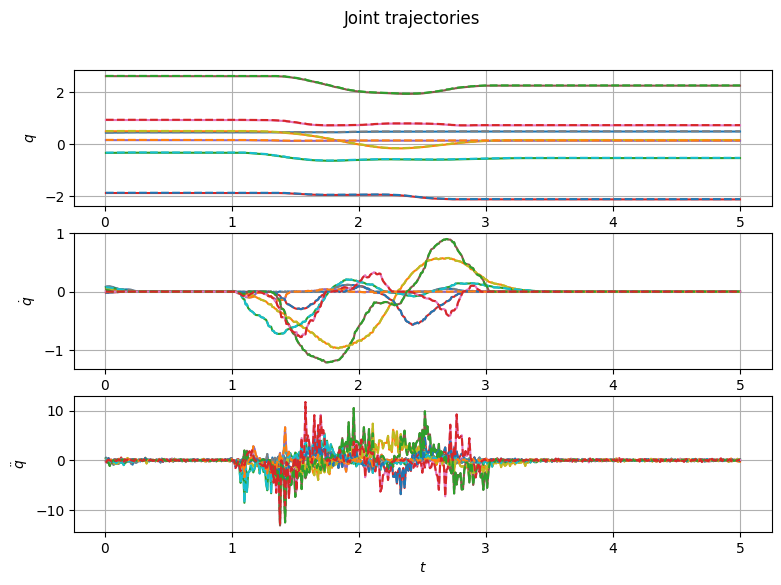

In [53]:
from robotblockset.graphics import plotjtraj
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle('Joint trajectories')
plotjtraj(tt, qt, dqt, ax=ax);
plotjtraj(tt, qt+0.01, dqt, ax=ax, linestyle="--");



**3. Naredite robota ponovno togega - na varen način - in izvedite posneto trajektorijo v prostoru sklepov na pribl. 100 Hz. Uporabite metodo `JPath` in `robot.GoTo_q` v zanki. Bodite pozorni, da skoki v referenčnih vrednostih niso preveliki!**

In [28]:
import utils
from utils import SoftSetJointCompliance


***PRED IZVEDBO TRAJEKTORIJE UPORABITE JMOVE V PRVO POZICIJO!!!***

In [54]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)

:Joint compliance changed 
Stiff:[1200. 1200. 1200. 1200.    0.    0.    0.]
Damp:[25 25 25 25 10 10 10]


In [55]:
r.JMove(qt[0],3)
N=np.size(qt,0)
for q, qdot, tm in zip(qt, dqt, np.diff(tt, axis=0)): 
    # Call the GoTo_q function
    r.GoTo_q(q,qdot,np.zeros(7),0)
    # time.sleep(1/100.)
    time.sleep(tm[0])

In [48]:
r.JMove(qt[0],3)
r.JPath(qt,5)

0

**4. Trajektorijo zapišite z uporabo DMP-jev (glej DMP.ipynb).**

In [51]:
print(tt.shape)

(1,)


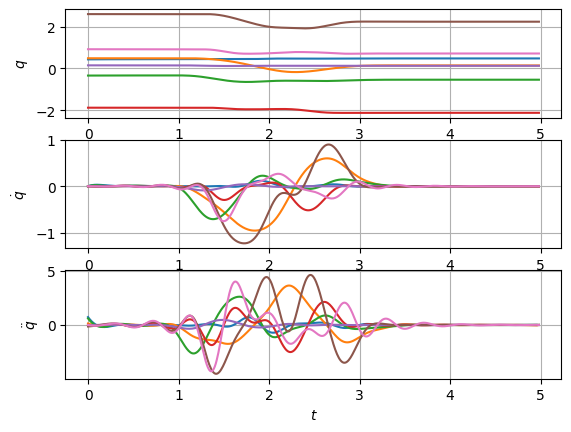

In [110]:
from dmp import DMP

d = DMP(qt.copy(),np.squeeze(tt.copy()),vel_data=dqt.copy(),num_weights=25)
trj_dec,t_dec=d.decode()
plotjtraj(qt=trj_dec, t=t_dec);

**5. Trajektorijo dekodirajte iz DMP-jev in jo narišite na isti plot kot osnovno, zajeto trajektorijo. Pozor! robot ima 7 sklepov!**

Predebatirajte sliko z asistentom

Unexpected exception formatting exception. Falling back to standard exception


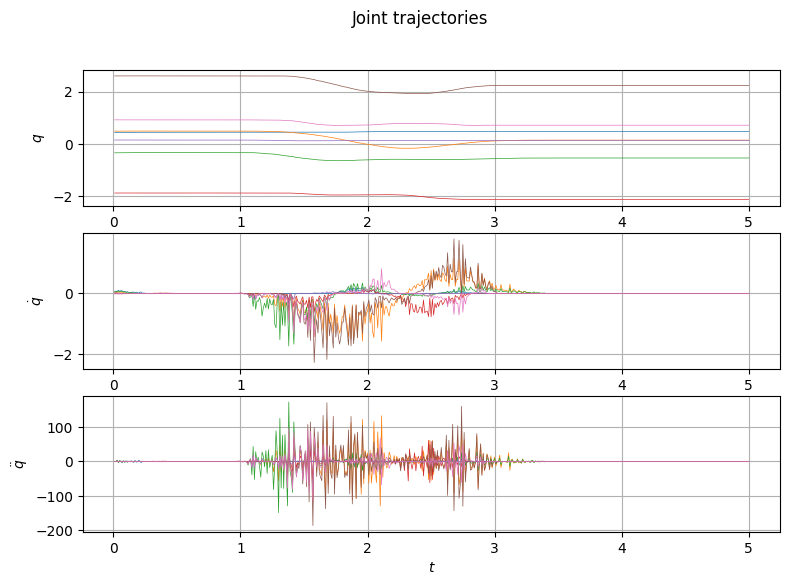

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle("Joint trajectories")
plotjtraj(tt, qt, ax=ax, linewidth=0.5)
plotjtraj(t_dec, trj_dec, ax=ax, linestyle="--")
plt.show()

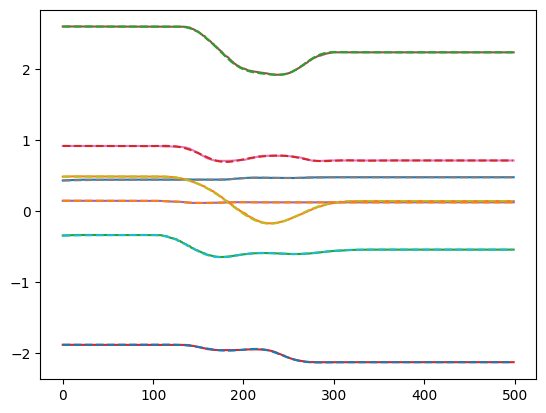

In [87]:
plt.plot(qt)
plt.plot(trj_dec, linestyle = "--")


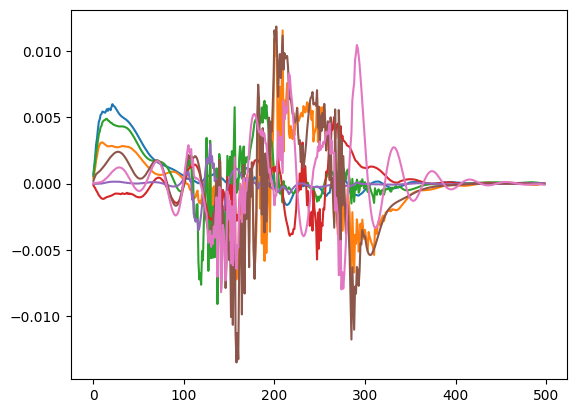

In [111]:
plt.plot(qt[1:]-trj_dec) #error of the DMP

**6. Narišite jedrne funkcije in uteži za en sklep.**

Najprej narišite fazo, nato narišite jedrne funkcije.
Narišite tudi jedrne funkcije za (en) poljuben sklep (pomnožene z utežmi).

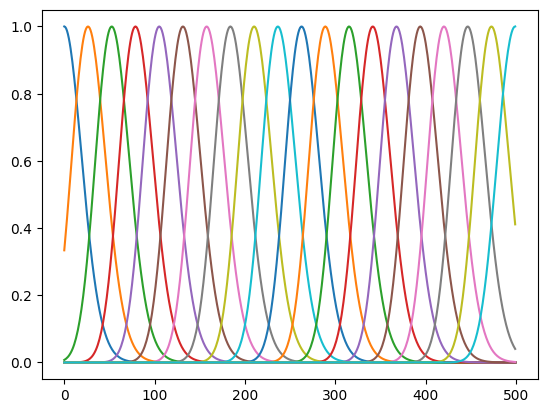

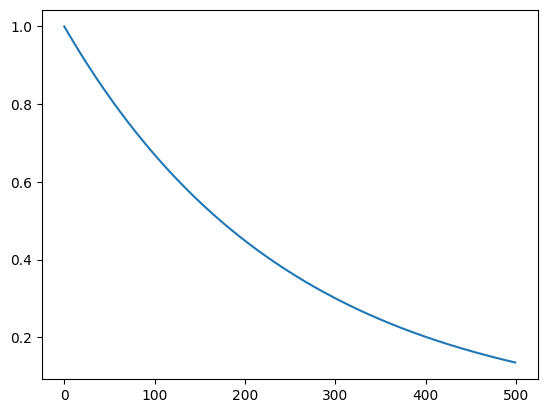

In [100]:
import numpy as np
import matplotlib.pyplot as plt


x = np.exp(-d.a_x * d._time_vec / d.tau)
psi = np.zeros((x.size, d.num_weights))
i = 0
for val in x:
    psi[i] = np.exp(- np.square(val-d.c) /
                 (np.multiply(d.sigma, 2)))
    i+=1

plt.plot(psi)
plt.show()
plt.plot(x)
plt.show()


(500, 20)


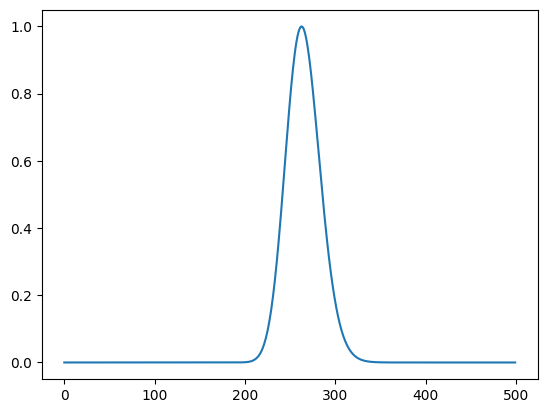

In [98]:
print(psi.shape)
plt.plot(psi[:,10])

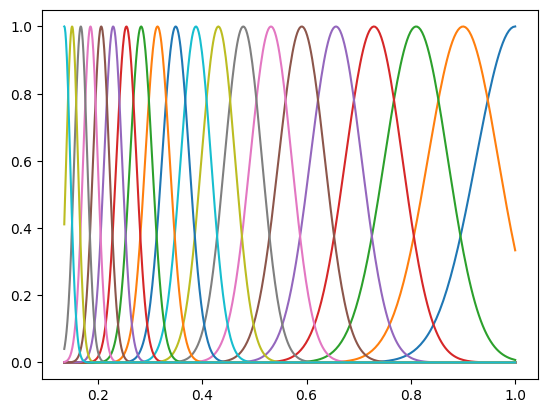

In [103]:
plt.plot(x,psi)
plt.show()

**7. Ponovno dekodirajte trajektorijo iz DMPja in jo izvedite z uporabo `robot.GoTo_q` v zanki.**

**8. Primerjajte trajektoriji iz obeh izvedb, ali je kaj razlike?**

**9. Spremenite hitrost izvajanja s spremembo parametrov DMP-ja - parameter za čas \tau. Nastavite, da se DMP izvede 2x hitreje in 2x počasneje.**

**10. Na nov plot narišite osnovno, pohitreno in upočasnjeno trajektorijo. Kako izgledajo.**

In [ ]:
# Dekodiraj časovno spremenjen DMP

fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle('Joint trajectories')
plotjtraj(tt, qt, dqt, ax=ax);
#plotjtraj(t=, qt=, ax=ax, linestyle="--");
plotjtraj(t=, qt=, ax=ax, linestyle="--");

**11. Pogovorite se z asistenti, kako bi isto spremembo hitrosti in izvedbo naredil brez uporabe DMPja.**

**12. Znova posnemite DMP v kartezijskem prostoru - zapišite samo pozicije. Orientacija naj bo konstantna in je ne zapisujte v DMP. Pogovorite se kaj je problem zapisa orientacij.**  
Pogovorite se z asistentom kakšno obliko naj ima nova trajektorija.

In [54]:
# Koda za zajem 


:Joint compliance changed 
Stiff:[0. 0. 0. 0. 0. 0. 0.]
Damp:[0. 0. 0. 0. 0. 0. 0.]


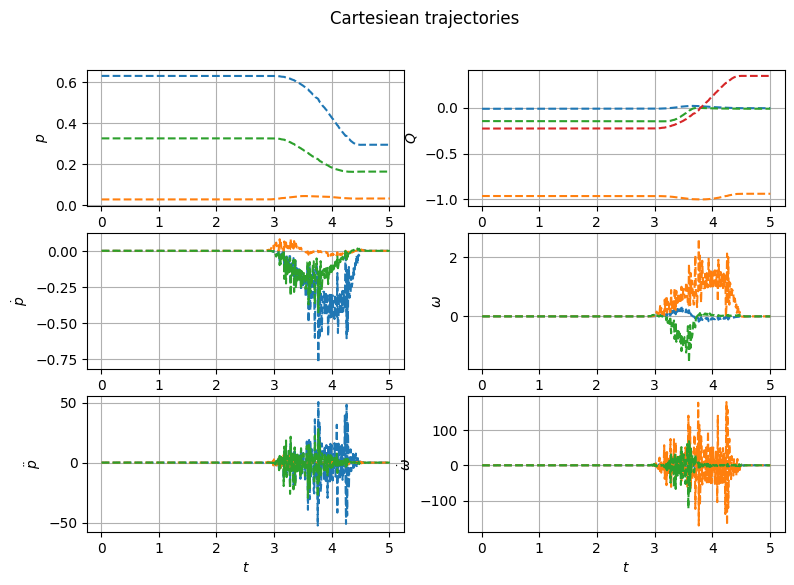

In [196]:
from robotblockset.graphics import plotctraj


fig, ax = plt.subplots(3, 2, figsize=(9, 6))
fig.suptitle("Cartesiean trajectories")
plotctraj(tt, xt, ax=ax, linestyle="--")

plt.show()

In [297]:
# Zakodiraj DMP s katezijsko trajektorijo, pri tem uporabite samo pozicije (x, y, z)
# POZOR! UPORABI COPY()


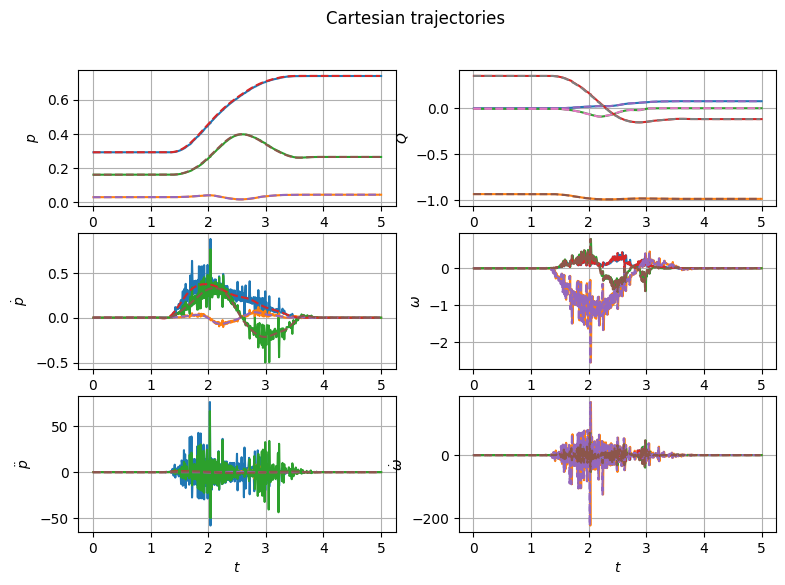

In [298]:
# Deokdiraj DMP v kartezijsko trajektorijo in jo izriši
# Bodi pozoren na vhodni parameter xt v funkciji plotctraj()


plt.show()

**13. Narišite x-y-z trajektorije na plot. Izvedite ta gib z robotom z uporabo CPath.**

**14. Malo spremenite cilj (g) DMPja in dekodirajte trajektorijo. Narišite jo na isti plot.**

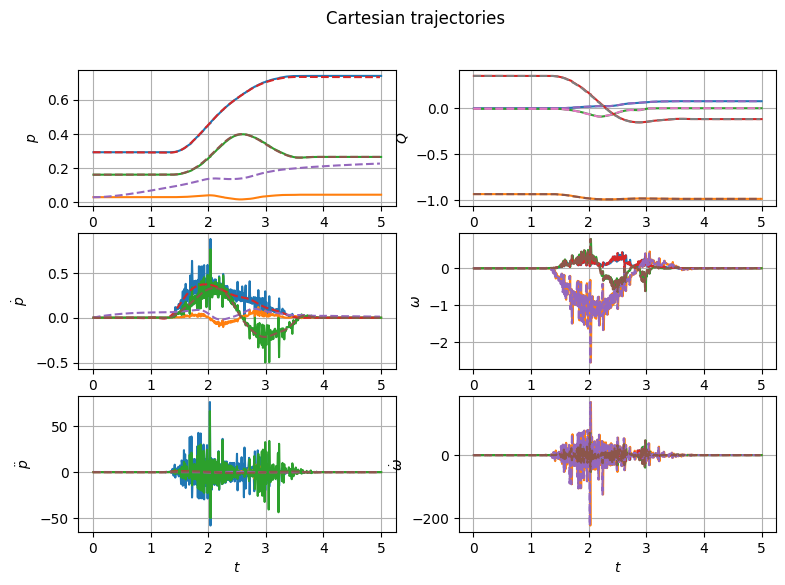

In [299]:



plt.show()

**15. Izvedite ta nov gib z uporabo CPath.**

0

**16. Ponovite kodiranje istega giba, kjer podate še parameter a_z. Ponovite koraka 14. in 15. Vse narišite na isti graf.**

**17. Poskusite spremeniti tudi čas izvajanja ter potem hkrati čas in cilj. Narišite te trajektorije ter jih tudi izvedite.**

**18. Narišite družino trajektorij, kjer se g spreminja, npr po 5 cm, od 0 do 30 cm.**

**19. Izvedite te trajektorije.**